<a href="https://colab.research.google.com/github/blowmeaway1234/Machine-Vision/blob/master/Model_Detection_Basketball_ver1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Google Drive Data 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!ls /content/drive/MyDrive/Basketball

test.zip  train.zip  validation.zip


In [ ]:
! unzip /content/drive/MyDrive/Basketball/train.zip
! unzip /content/drive/MyDrive/Basketball/test.zip
! unzip /content/drive/MyDrive/Basketball/validation.zip

In [ ]:
 # lệnh !ls không hiểu python nên ko dùng '{}'.format i
!ls test
for i in range(2):
  !ls validation/{i}| wc -l
!ls test
for i in range(2): # lệnh !ls không hiểu python nên ko dùng '{}'.format i
  !ls train/{i}| wc -l

# Build Data Pipe line

In [22]:
# import library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam 

In [23]:
# Part data train
train_root = Path('train/')
filelist_Training = tf.data.Dataset.list_files(str(train_root/'*/*')) 

# Part data test
test_root = Path('test/')
filelist_Testing = tf.data.Dataset.list_files(str(test_root/'*/*'))

# Part data validation
val_root = Path('validation/')
filelist_Validation = tf.data.Dataset.list_files(str(val_root/'*/*'))  


In [24]:
for file in filelist_Training.take(2):
  print('filename:',file.numpy().decode('utf-8')) # Decode tf.tensor to utf8
for file in filelist_Testing.take(2):
  print('filename:',file.numpy().decode('utf-8')) # Decode tf.tensor to utf8
for file in filelist_Validation.take(2):
  print('filename:',file.numpy().decode('utf-8')) # Decode tf.tensor to utf8

filename: train/1/m (352).jpg
filename: train/1/m (16).jpg
filename: test/0/t (140).jpg
filename: test/0/t (128).jpg
filename: validation/1/v (88).jpg
filename: validation/1/v (6).jpg


In [25]:
#Preprocessing
def preprocessing(file_path):
  #Readfile
  img1 = tf.io.read_file(file_path)
  img1 = tf.image.decode_jpeg(img1,channels=3) #Read Color image
  img1 = tf.image.rgb_to_grayscale(img1, name=None) # convert to gray scale
  #Transform
  img1 = tf.image.convert_image_dtype(img1,tf.float32) # convert uint8 to float and normalize [0,1]
  #Resize image
  img1 = tf.image.resize(img1,[img_width,img_height])
  #-4. Reshape -> vector hàng
  img1 = tf.reshape(img1,(28,28,1))
  #Get image lable
  label = get_label(file_path) #sự dụng hàm test label vừa tạo
  #Return
  return img1,label#Preprocessing

In [26]:
# Make Label
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  if parts[-2] == "0":
    labels=[1,0] 
  else:
    labels=[0,1] 
  return tf.convert_to_tensor(labels)

In [27]:
#Global Value
batch_size= 32                     
img_height = 28
img_width = 28

datatrain_size = 802 #(shuffle size_train) 
datatest_size = 196 #(shuffle test) 
dataval_size = 177

reshapesize= img_height*img_width
print("Value Reshapsize",reshapesize)

Value Reshapsize 784


In [28]:
#build data training
train_dataset = filelist_Training.shuffle(datatrain_size) 
train_dataset = train_dataset.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE) # Process each element + get labels => train_ds = pixel val and labels
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(2) # chia luồn data

In [29]:
#build validation data
test_dataset_validation = filelist_Validation.shuffle(dataval_size) 
test_dataset_validation = test_dataset_validation.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE) # Process each element + get labels => train_ds = pixel val and labels
test_dataset_validation = test_dataset_validation.batch(batch_size)
test_dataset_validation = test_dataset_validation.prefetch(2) # chia luồn data

In [30]:
#build data testing
test_dataset = filelist_Testing.shuffle(datatest_size) 
test_dataset = test_dataset.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE) # Process each element + get labels => train_ds = pixel val and labels
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(2) # chia luồn data

#Build Model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 10)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 20)          5020      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dropout_1 (Dropout)         (None, 320)              

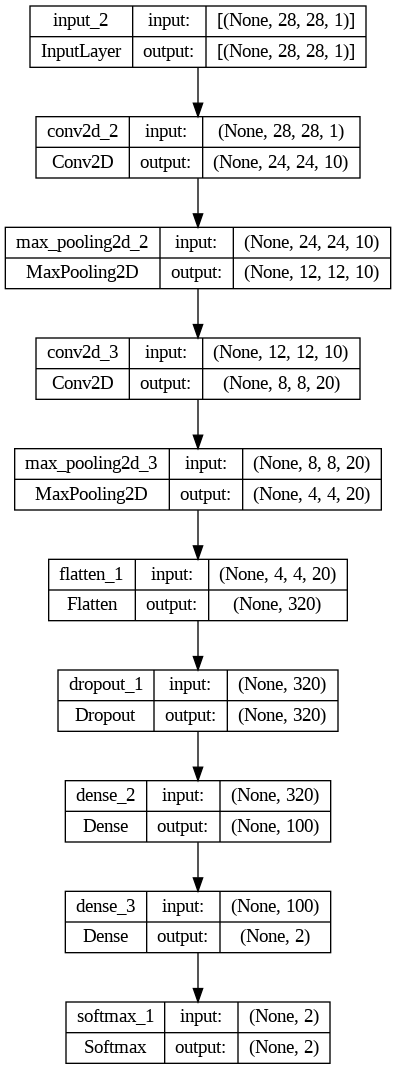

In [31]:
# Build CNN model using function API
# Convolutional Neural Network

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(img_height,img_width,1)))
model.add(layers.Conv2D(10,5, strides=(1,1), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
model.add(layers.Conv2D(20,5,strides=(1,1), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2))
model.add(layers.Softmax())

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy']) # Compile model
model.summary()

# Draw Graph
tf.keras.utils.plot_model(model,'model.png',show_shapes=True)


#Train Model

Epoch 1/30
30/30 [==============================] - 106s 3s/step - loss: 0.5477 - accuracy: 0.8088 - val_loss: 0.5244 - val_accuracy: 0.8757
Epoch 2/30
30/30 [==============================] - 99s 3s/step - loss: 0.4623 - accuracy: 0.8161 - val_loss: 0.3996 - val_accuracy: 0.9153
Epoch 3/30
30/30 [==============================] - 103s 3s/step - loss: 0.3584 - accuracy: 0.8757 - val_loss: 0.3374 - val_accuracy: 0.9209
Epoch 4/30
30/30 [==============================] - 105s 4s/step - loss: 0.3246 - accuracy: 0.8997 - val_loss: 0.3345 - val_accuracy: 0.9153
Epoch 5/30
30/30 [==============================] - 104s 3s/step - loss: 0.3225 - accuracy: 0.8966 - val_loss: 0.2931 - val_accuracy: 0.9266
Epoch 6/30
30/30 [==============================] - 102s 3s/step - loss: 0.2694 - accuracy: 0.9112 - val_loss: 0.2377 - val_accuracy: 0.9435
Epoch 7/30
30/30 [==============================] - 102s 3s/step - loss: 0.2201 - accuracy: 0.9269 - val_loss: 0.2375 - val_accuracy: 0.9266
Epoch 8/30
30/

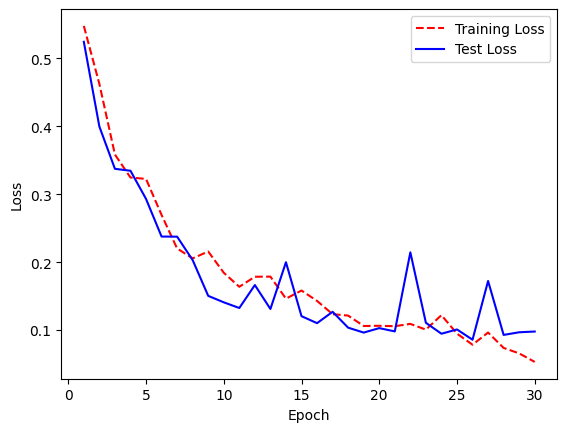

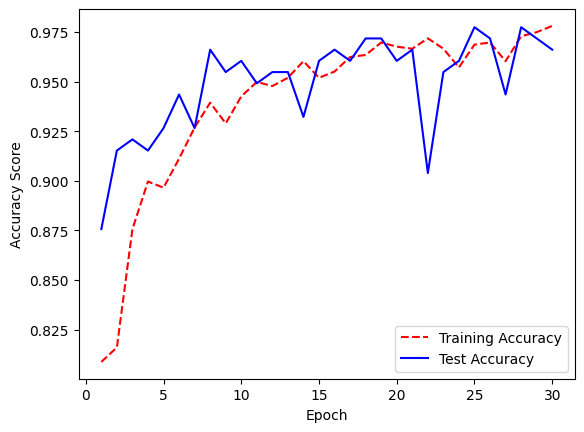

In [32]:
# Train model
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset_validation)

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show()

model.save('CNN_Bask_Rec.h5')

# Evaluate

13/13 [==============================] - 35s 3s/step - loss: 0.1134 - accuracy: 0.9327
Test Loss: 0.1134307011961937
Test Accuracy: 0.932692289352417
1/1 [==============================] - 0s 18ms/step
Precision: 0.9210526315789473
Recall: 0.9545454545454546
F1-score: 0.9375
Confusion Matrix:
[[178  18]
 [ 10 210]]


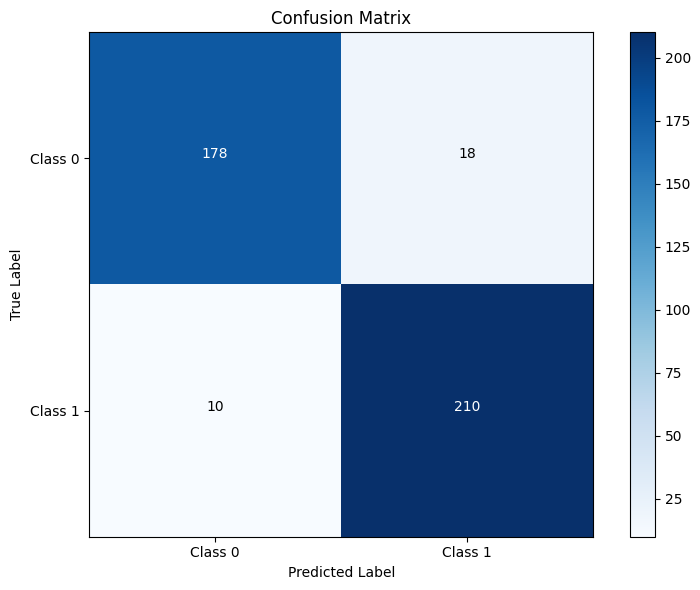

In [43]:
# Evaluate model on test dataset
evaluation = model.evaluate(test_dataset)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Lấy nhãn thực tế và nhãn dự đoán từ test_dataset
y_test = []
y_pred = []
for image, label in test_dataset:
    # Dự đoán nhãn cho từng ảnh trong test_dataset
    predictions = model.predict(image)
    # Lấy nhãn dự đoán của mỗi ảnh
    predicted_labels = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_labels)
    # Lấy nhãn thực tế của mỗi ảnh
    true_labels = np.argmax(label.numpy(), axis=1)
    y_test.extend(true_labels)

# Chuyển đổi y_test và y_pred thành numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

# Tính toán confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# In kết quả confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

# Vẽ biểu đồ confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = ["Class 0", "Class 1"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Đánh dấu số lượng mẫu trong từng ô của confusion matrix
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

plt.show()